In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Unzip it
!unzip ravdess-emotional-speech-audio.zip -d ravdess


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 98% 420M/429M [00:02<00:00, 137MB/s] 
100% 429M/429M [00:02<00:00, 159MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import random


In [3]:
DATASET_PATH = "/content/ravdess"  # عدل هذا المسار لمسار بياناتك

EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


In [4]:
wav_files = []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f"Total WAV files found: {len(wav_files)}")
print("Sample files:")
print("\n".join(wav_files[:10]))


Total WAV files found: 2880
Sample files:
/content/ravdess/Actor_07/03-01-07-01-01-01-07.wav
/content/ravdess/Actor_07/03-01-04-02-02-01-07.wav
/content/ravdess/Actor_07/03-01-06-01-02-01-07.wav
/content/ravdess/Actor_07/03-01-06-02-01-01-07.wav
/content/ravdess/Actor_07/03-01-08-01-01-02-07.wav
/content/ravdess/Actor_07/03-01-02-02-02-02-07.wav
/content/ravdess/Actor_07/03-01-03-02-02-01-07.wav
/content/ravdess/Actor_07/03-01-08-02-01-02-07.wav
/content/ravdess/Actor_07/03-01-08-01-02-01-07.wav
/content/ravdess/Actor_07/03-01-02-02-02-01-07.wav


In [5]:
def get_emotion_label(filename):
    # الاسم يحتوي على أرقام مفصولة بـ -
    emotion_code = filename.split("-")[2]
    return EMOTION_MAP.get(emotion_code)

labels = [get_emotion_label(os.path.basename(f)) for f in wav_files]

counter = Counter(labels)
print("Emotion distribution:")
for emotion, count in counter.items():
    print(f"{emotion}: {count}")


Emotion distribution:
disgust: 384
sad: 384
fearful: 384
surprised: 384
calm: 384
happy: 384
angry: 384
neutral: 192


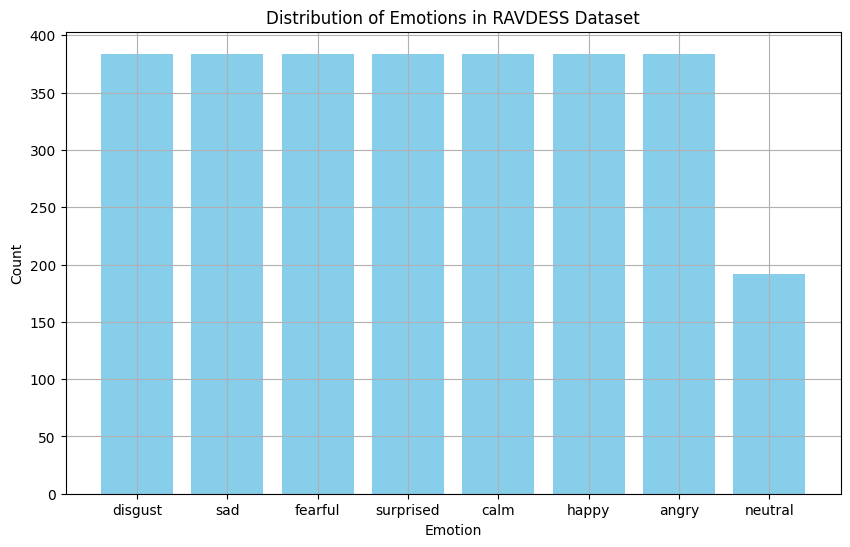

In [6]:
plt.figure(figsize=(10,6))
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.title("Distribution of Emotions in RAVDESS Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import librosa

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    # تأكد أن الإشارة ضمن [-1,1]
    augmented_audio = np.clip(augmented_audio, -1, 1)
    return augmented_audio

def shift_time(audio, sr, shift_max=0.2):
    shift = int(sr * shift_max * np.random.uniform(-1, 1))
    return np.roll(audio, shift)

def change_pitch(audio, sr, pitch_range=2):
    n_steps = np.random.uniform(-pitch_range, pitch_range)
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def stretch_audio(audio, rate=1.0):
    return librosa.effects.time_stretch(audio, rate)


In [8]:
import random

def extract_augmented_features(file_path, max_pad_len=174, augment=True, mode=None):
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')

    if augment:
        if mode:
            choice = mode
        else:
            choice = random.choice(['none', 'noise', 'shift', 'pitch', 'stretch'])

        if choice == 'noise':
            audio = add_noise(audio)
        elif choice == 'shift':
            audio = shift_time(audio, sr)
        elif choice == 'pitch':
            audio = change_pitch(audio, sr)
        elif choice == 'stretch':
            try:
                audio = stretch_audio(audio, rate=random.uniform(0.8, 1.2))
            except:
                pass

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    return mfcc


In [9]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.8 MB/s eta 0:00:00


In [10]:
features = []
labels = []

max_count = 384  # أكبر عدد لعينة لكل فئة (مثلاً عدد فئة 'disgust')

for file_path in wav_files:
    emotion_code = os.path.basename(file_path).split("-")[2]
    emotion = EMOTION_MAP.get(emotion_code)

    # الأصلية
    mfcc = extract_augmented_features(file_path, augment=False)
    features.append(mfcc)
    labels.append(emotion)

    # Augmentation عشوائي لكل الفئات
    mfcc_aug = extract_augmented_features(file_path, augment=True)
    features.append(mfcc_aug)
    labels.append(emotion)

    # تعزيز خاص لـ neutral إذا كانت العينات أقل
    if emotion == "neutral":
        needed = max_count - labels.count("neutral")
        while needed > 0:
            # يمكن تزيد augmentations مختلفة
            mfcc_noise = extract_augmented_features(file_path, augment=True, mode='noise')
            mfcc_stretch = extract_augmented_features(file_path, augment=True, mode='stretch')
            features.extend([mfcc_noise, mfcc_stretch])
            labels.extend(["neutral"]*2)
            needed -= 2


In [11]:
from collections import Counter
counter = Counter(labels)
print("Balanced emotion distribution:")
for emo, cnt in counter.items():
    print(f"{emo}: {cnt}")


Balanced emotion distribution:
disgust: 768
sad: 768
fearful: 768
surprised: 768
calm: 768
happy: 768
angry: 768
neutral: 766


In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ترميز النصوص لأرقام
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# تحويل للأشكال التي تناسب التصنيف المتعدد (one-hot encoding)
y_categorical = to_categorical(y_encoded)


In [13]:
from sklearn.model_selection import train_test_split

X = np.array(features)  # يجب أن تكون مصفوفة NumPy شكلها (num_samples, num_features, time_steps)
y = y_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 4913, Test samples: 1229


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization

model = Sequential()
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 40, 174)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 64)         │        61,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,656 (389.28 KB)

 Trainable params: 99,272 (387.78 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2005 - loss: 2.6056 - val_accuracy: 0.3792 - val_loss: 1.7027
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2949 - loss: 1.9332 - val_accuracy: 0.4500 - val_loss: 1.5156
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3790 - loss: 1.6718 - val_accuracy: 0.5061 - val_loss: 1.3934
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4801 - loss: 1.4589 - val_accuracy: 0.5460 - val_loss: 1.3011
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5328 - loss: 1.2997 - val_accuracy: 0.5875 - val_loss: 1.1842
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6163 - loss: 1.1097 - val_accuracy: 0.6509 - val_loss: 1.0779
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6400 - loss: 1.0286 - val_accuracy: 0.6501 - val_loss: 1.0410
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6836 - loss: 0.9307 - val_acc

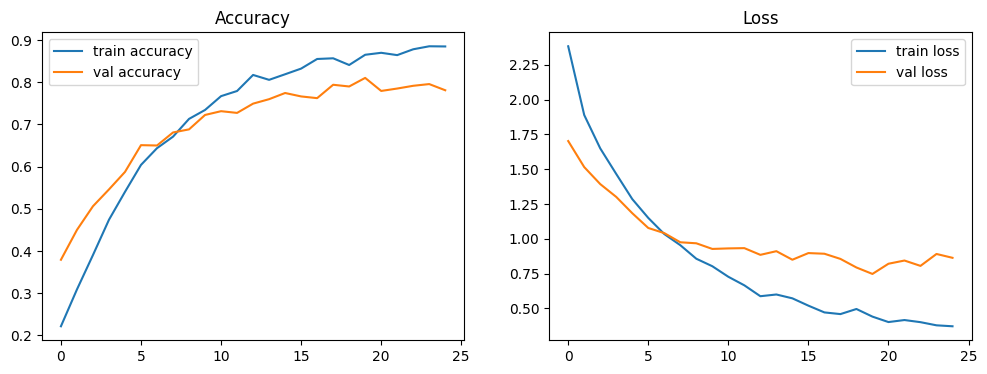

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


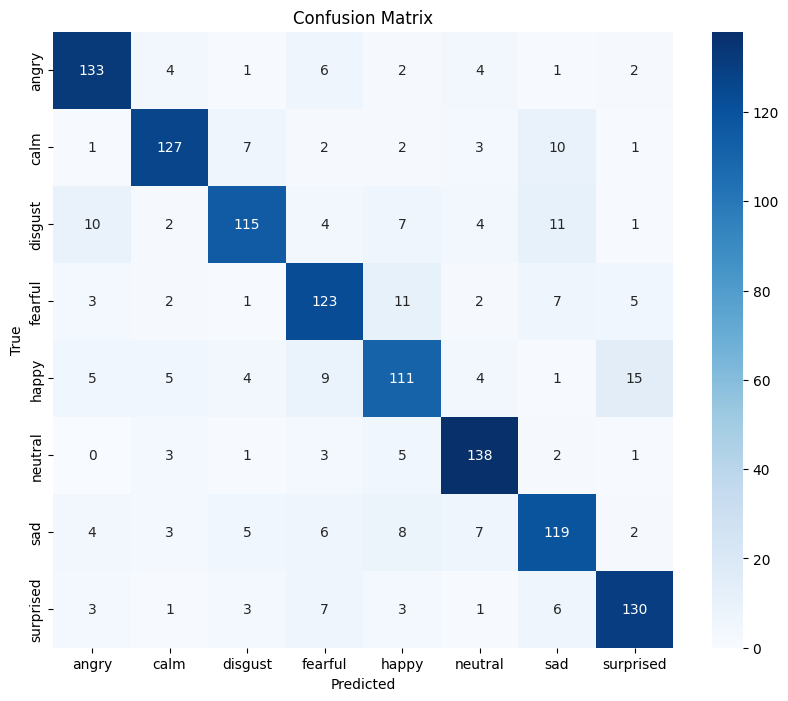

Classification Report:

              precision    recall  f1-score   support

       angry       0.84      0.87      0.85       153
        calm       0.86      0.83      0.85       153
     disgust       0.84      0.75      0.79       154
     fearful       0.77      0.80      0.78       154
       happy       0.74      0.72      0.73       154
     neutral       0.85      0.90      0.87       153
         sad       0.76      0.77      0.77       154
   surprised       0.83      0.84      0.84       154

    accuracy                           0.81      1229
   macro avg       0.81      0.81      0.81      1229
weighted avg       0.81      0.81      0.81      1229



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# حساب التوقعات
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)
labels_names = le.classes_  # أسماء الفئات

# رسم المصفوفة
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names,
            yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# تقرير التصنيف
report = classification_report(y_true, y_pred, target_names=labels_names)
print("Classification Report:\n")
print(report)


In [18]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 7.6 MB/s eta 0:00:00


In [19]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, Normalize, HighPassFilter, LowPassFilter, RoomSimulator

advanced_augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.85, max_rate=1.15, p=0.5),
    PitchShift(min_semitones=-3, max_semitones=3, p=0.5),
    Shift(min_shift=-0.3, max_shift=0.3, shift_unit="fraction", p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
    HighPassFilter(min_cutoff_freq=200, max_cutoff_freq=3000, p=0.5),
    LowPassFilter(min_cutoff_freq=300, max_cutoff_freq=8000, p=0.5),
    RoomSimulator(p=0.3)  # لمحاكاة الصدى
])

def augment_audio(audio, sr, augment=False):
    if augment:
        audio = advanced_augmenter(samples=audio, sample_rate=sr)
    return audio


In [20]:
from collections import defaultdict

emotion_files = defaultdict(list)

for file_path in wav_files:
    label = get_emotion_label(os.path.basename(file_path))
    if label:
        emotion_files[label].append(file_path)

In [21]:
!pip install noisereduce

In [22]:
import librosa
import noisereduce as nr
import numpy as np

def reduce_noise(audio, sr):
    noise_sample = audio[0:int(sr*0.5)]  # أول نصف ثانية كعينة للضجيج
    return nr.reduce_noise(y=audio, y_noise=noise_sample, sr=sr)

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def load_and_clean_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

In [23]:
!pip install pyroomacoustics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 39.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.4-cp311-cp311-linux_x86_64.whl size=46813650 sha256=1647e12056f492e8e021f0ab66c3c5d36f3c4a9ce9fb101d2344add5fb9fe71a
  Stored in directory: /root/.cache/pip/wheels/3d/ce/d3/12469dccc93a4a2eadfe064ca0519539fc8bdf0d970a33795f
Successfully built pyroomacoustics


In [24]:
def extract_features_from_audio(audio, sr, max_pad_len=174):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

In [25]:
# زيادة العينات المعززة فقط للفئات الأقل أداءً
target_emotions = ['sad', 'disgust']  # يمكن تعديلهم حسب التقرير

for emotion in target_emotions:
    files_list = emotion_files[emotion]
    current_count = len(files_list)
    extra_needed = 200  # عدد العينات التي ترغب بإضافتها

    for _ in range(extra_needed):
        file_path = random.choice(files_list)
        audio, sr = load_and_clean_audio(file_path)
        audio_aug = augment_audio(audio, sr, augment=True)
        feat_aug = extract_features_from_audio(audio_aug, sr)
        features.append(feat_aug)
        labels.append(emotion)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional

model = Sequential()

# Masking for padded sequences
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 40, 174)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 40, 128)        │       122,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,240 (903.28 KB)

 Trainable params: 230,600 (900.78 KB)

 Non-trainable params: 640 (2.50 KB)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# إعداد EarlyStopping لتجنب الإفراط في التدريب
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1998 - loss: 2.6421 - val_accuracy: 0.3662 - val_loss: 1.7334
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3406 - loss: 1.8554 - val_accuracy: 0.4833 - val_loss: 1.4356
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4151 - loss: 1.5694 - val_accuracy: 0.5566 - val_loss: 1.2701
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4830 - loss: 1.3998 - val_accuracy: 0.6119 - val_loss: 1.1163
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5758 - loss: 1.1779 - val_accuracy: 0.6452 - val_loss: 1.0224
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6306 - loss: 1.0264 - val_accuracy: 0.7201 - val_loss: 0.8493
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7044 - loss: 0.8451 - val_accuracy: 0.7307 - val_loss: 0.8181
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7544 - loss: 0.6974 - val_accu

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

     neutral       0.85      0.92      0.88       153
        calm       0.87      0.89      0.88       153
       happy       0.85      0.86      0.86       154
         sad       0.92      0.83      0.87       154
       angry       0.82      0.84      0.83       154
     fearful       0.92      0.95      0.94       153
     disgust       0.78      0.82      0.80       154
   surprised       0.93      0.82      0.87       154

    accuracy                           0.87      1229
   macro avg       0.87      0.87      0.87      1229
weighted avg       0.87      0.87      0.87      1229



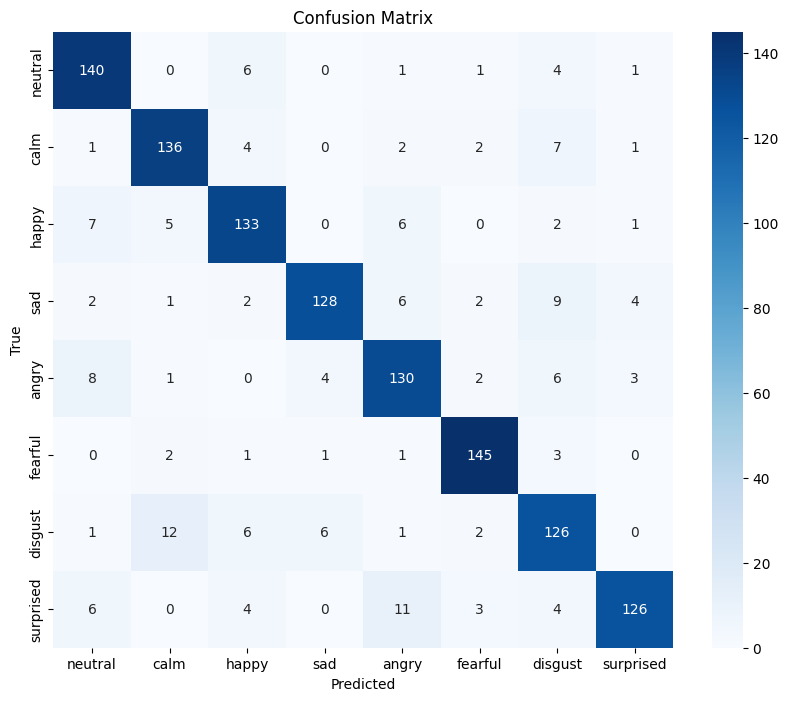

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# توقعات الموديل على بيانات الاختبار
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# عرض classification report
print(classification_report(y_true, y_pred, target_names=list(EMOTION_MAP.values())))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم مصفوفة الالتباس بشكل أجمل
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()),
            yticklabels=list(EMOTION_MAP.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


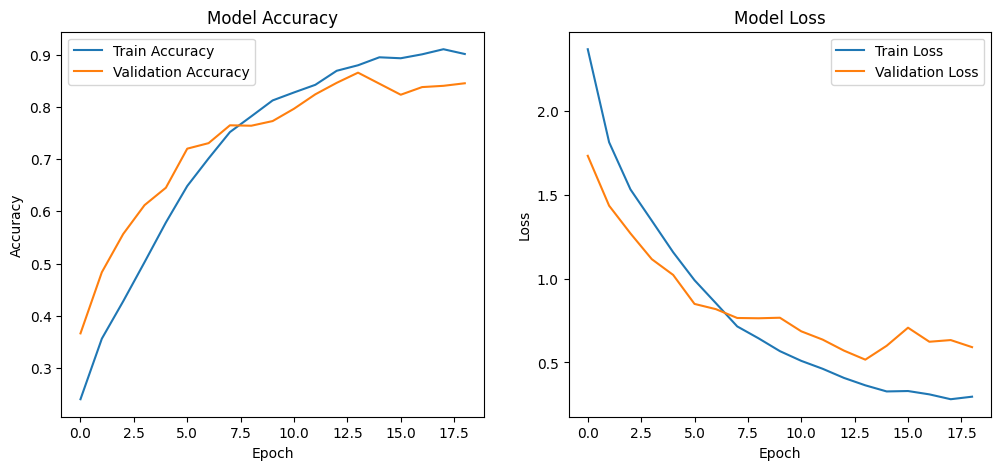

In [45]:
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [46]:
model.save("best_model.h5")

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional

model = Sequential()

# Masking for padded sequences
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 40, 174)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 40, 64)         │        52,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,808 (315.66 KB)

 Trainable params: 80,488 (314.41 KB)

 Non-trainable params: 320 (1.25 KB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# إعداد EarlyStopping لتجنب الإفراط في التدريب
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.1612 - loss: 2.7957 - val_accuracy: 0.2856 - val_loss: 1.8815
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2325 - loss: 2.1568 - val_accuracy: 0.3417 - val_loss: 1.7210
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2828 - loss: 1.9015 - val_accuracy: 0.3938 - val_loss: 1.6370
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3113 - loss: 1.7892 - val_accuracy: 0.4288 - val_loss: 1.5650
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3364 - loss: 1.7218 - val_accuracy: 0.4524 - val_loss: 1.5156
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3998 - loss: 1.5936 - val_accuracy: 0.4638 - val_loss: 1.4759
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3966 - loss: 1.5781 - val_accuracy: 0.4817 - val_loss: 1.4016
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4030 - loss: 1.5191 - val_accu

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

     neutral       0.80      0.82      0.81       153
        calm       0.77      0.78      0.78       153
       happy       0.78      0.75      0.77       154
         sad       0.70      0.77      0.73       154
       angry       0.70      0.72      0.71       154
     fearful       0.85      0.87      0.86       153
     disgust       0.80      0.62      0.70       154
   surprised       0.73      0.79      0.76       154

    accuracy                           0.76      1229
   macro avg       0.77      0.76      0.76      1229
weighted avg       0.77      0.76      0.76      1229



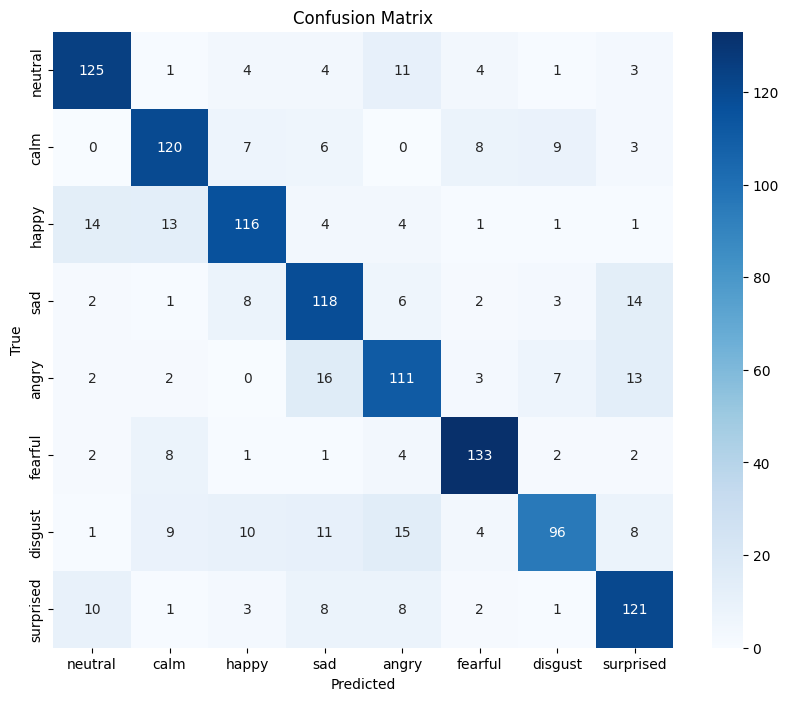

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# توقعات الموديل على بيانات الاختبار
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# عرض classification report
print(classification_report(y_true, y_pred, target_names=list(EMOTION_MAP.values())))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم مصفوفة الالتباس بشكل أجمل
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()),
            yticklabels=list(EMOTION_MAP.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


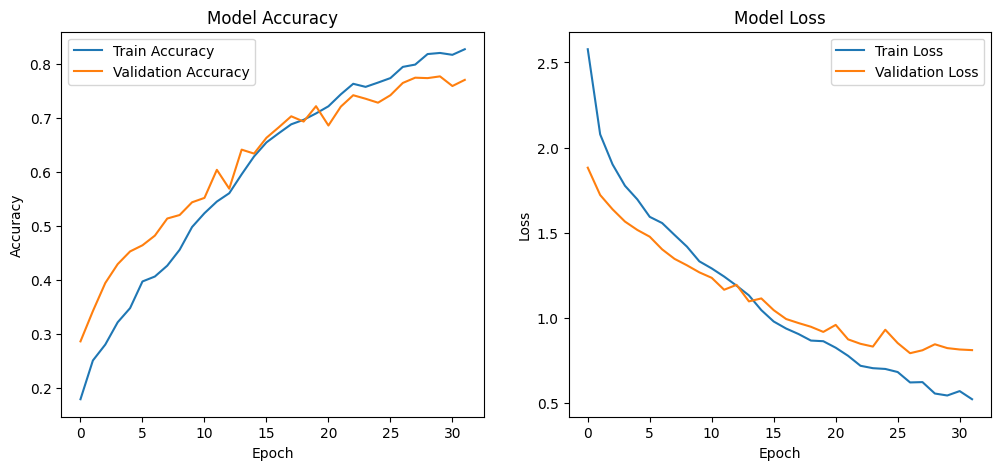

In [33]:
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional

model = Sequential()

# Masking for padded sequences
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 40, 174)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 40, 128)        │       122,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,240 (903.28 KB)

 Trainable params: 230,600 (900.78 KB)

 Non-trainable params: 640 (2.50 KB)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# إعداد EarlyStopping لتجنب الإفراط في التدريب
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1944 - loss: 2.6215 - val_accuracy: 0.3613 - val_loss: 1.7425
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3043 - loss: 1.9579 - val_accuracy: 0.4410 - val_loss: 1.5207
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3731 - loss: 1.6826 - val_accuracy: 0.4882 - val_loss: 1.3975
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4554 - loss: 1.4823 - val_accuracy: 0.5753 - val_loss: 1.2349
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5114 - loss: 1.3096 - val_accuracy: 0.6168 - val_loss: 1.0896
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5723 - loss: 1.1427 - val_accuracy: 0.6631 - val_loss: 0.9790
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6470 - loss: 0.9791 - val_accuracy: 0.6941 - val_loss: 0.9306
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6910 - loss: 0.8711 - val_accu

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

     neutral       0.90      0.84      0.87       153
        calm       0.73      0.84      0.78       153
       happy       0.87      0.79      0.83       154
         sad       0.76      0.90      0.82       154
       angry       0.82      0.79      0.80       154
     fearful       0.87      0.91      0.89       153
     disgust       0.74      0.72      0.73       154
   surprised       0.88      0.76      0.82       154

    accuracy                           0.82      1229
   macro avg       0.82      0.82      0.82      1229
weighted avg       0.82      0.82      0.82      1229



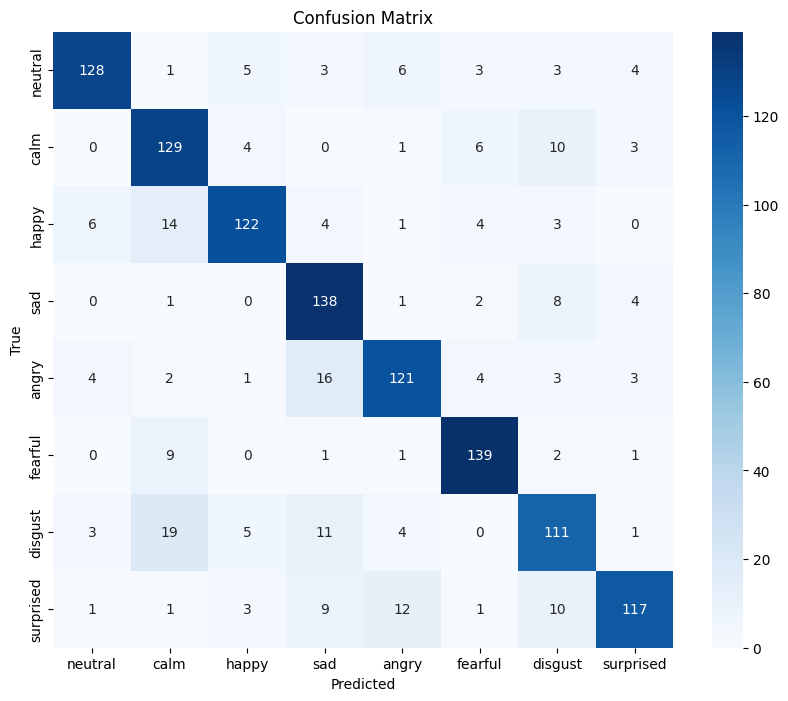

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# توقعات الموديل على بيانات الاختبار
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# عرض classification report
print(classification_report(y_true, y_pred, target_names=list(EMOTION_MAP.values())))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم مصفوفة الالتباس بشكل أجمل
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()),
            yticklabels=list(EMOTION_MAP.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


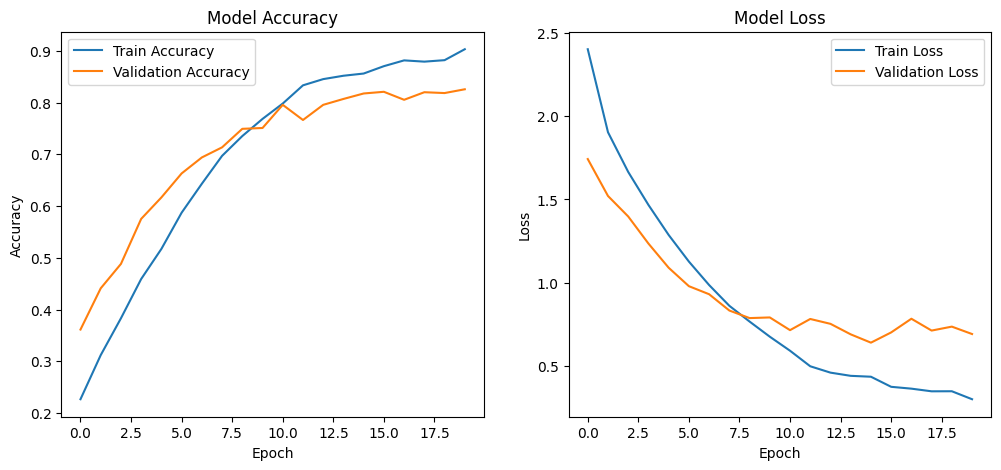

In [37]:
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional

model = Sequential()

# Masking for padded sequences
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 40, 174)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 40, 128)        │       122,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,240 (903.28 KB)

 Trainable params: 230,600 (900.78 KB)

 Non-trainable params: 640 (2.50 KB)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# إعداد EarlyStopping لتجنب الإفراط في التدريب
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2095 - loss: 2.5634 - val_accuracy: 0.4117 - val_loss: 1.5841
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3403 - loss: 1.8310 - val_accuracy: 0.5020 - val_loss: 1.3799
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4198 - loss: 1.5851 - val_accuracy: 0.5403 - val_loss: 1.2456
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4988 - loss: 1.3528 - val_accuracy: 0.6192 - val_loss: 1.1135
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5656 - loss: 1.2047 - val_accuracy: 0.6656 - val_loss: 1.0128
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6146 - loss: 1.0643 - val_accuracy: 0.6892 - val_loss: 0.9110
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6890 - loss: 0.8982 - val_accuracy: 0.7120 - val_loss: 0.8727
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7255 - loss: 0.7879 - val_a

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

     neutral       0.86      0.88      0.87       153
        calm       0.86      0.81      0.83       153
       happy       0.84      0.83      0.83       154
         sad       0.76      0.87      0.81       154
       angry       0.86      0.73      0.79       154
     fearful       0.83      0.86      0.85       153
     disgust       0.78      0.79      0.79       154
   surprised       0.84      0.84      0.84       154

    accuracy                           0.83      1229
   macro avg       0.83      0.83      0.83      1229
weighted avg       0.83      0.83      0.83      1229



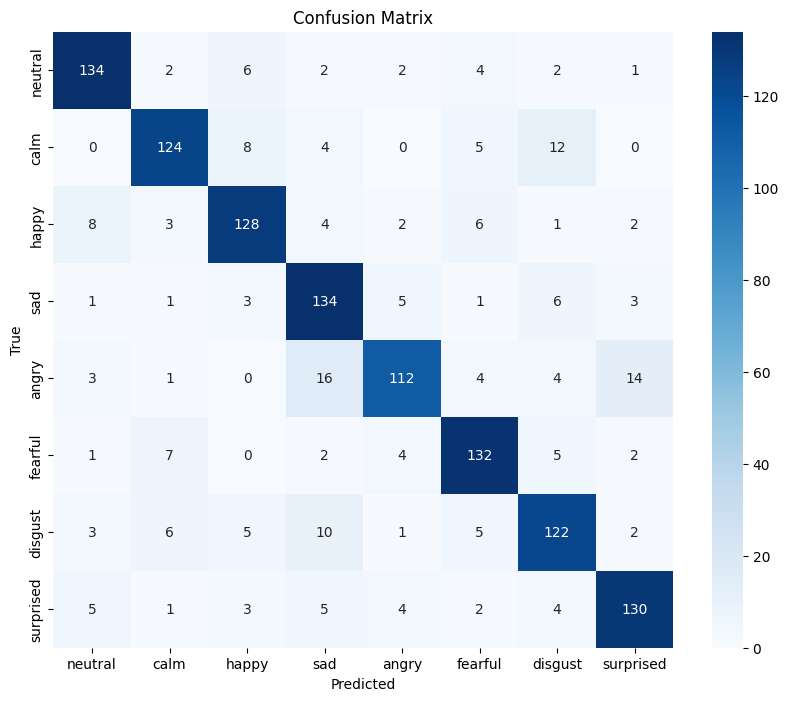

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# توقعات الموديل على بيانات الاختبار
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# عرض classification report
print(classification_report(y_true, y_pred, target_names=list(EMOTION_MAP.values())))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم مصفوفة الالتباس بشكل أجمل
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()),
            yticklabels=list(EMOTION_MAP.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


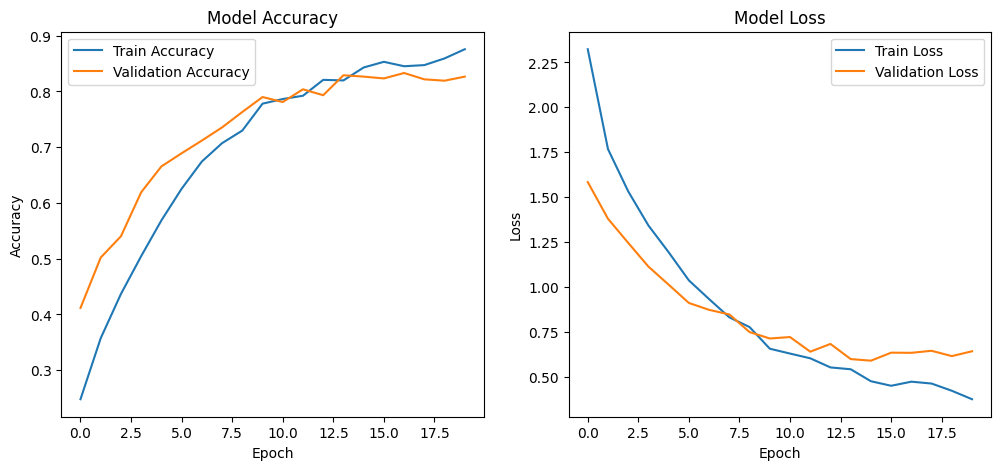

In [41]:
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model.save("best_model.h5")

In [ ]:
from google.colab import files
files.download('best_model.h5')  # This will download the file to your PC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>